In [1]:
import os
import ot
from ot import emd2, emd  # POT package for EMD computation
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
import jax
import jax.numpy as jnp
import numpy as np
from jax import random, grad, vmap, jit, hessian
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu

from jax import lax
from jax.flatten_util import ravel_pytree
from jax import device_get

import itertools
from functools import partial
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import time
import scipy.optimize as sp_opt


import numpy as np
from scipy.stats import ortho_group
from scipy.linalg import sqrtm
import flax
import flax.linen as nn
from matplotlib.ticker import FuncFormatter


from scipy.interpolate import griddata
from scipy.sparse import csr_matrix
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
OUTPUT_SEED = 0xC0FFEE

/tmp/ipykernel_1129792/2678599469.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


gpu


In [3]:
np.random.seed(OUTPUT_SEED)
dim = 128
rotation_source = ortho_group.rvs(dim)
rotation_target = ortho_group.rvs(dim)

dim = rotation_source.shape[0]

def symmetrize(X):
    return np.real((X + X.T) / 2)

weight_source = rotation_source @ np.diag(np.exp(np.linspace(np.log(0.5), np.log(2), dim)))
sigma_source = weight_source @ weight_source.T

weight_target = rotation_target @ np.diag(np.exp(np.linspace(np.log(0.5), np.log(2), dim)))
sigma_target = weight_target @ weight_target.T

root_sigma_X = symmetrize(sqrtm(sigma_source))
inv_root_sigma_X = symmetrize(np.linalg.inv(root_sigma_X))

root_sigma_Y = symmetrize(sqrtm(sigma_target))
inv_root_sigma_Y = symmetrize(np.linalg.inv(root_sigma_Y))

map_XY = inv_root_sigma_X @ symmetrize(sqrtm(root_sigma_X @ sigma_target @ root_sigma_X)) @ inv_root_sigma_X

map_YX = inv_root_sigma_Y @ symmetrize(sqrtm(root_sigma_Y @ sigma_source @ root_sigma_Y)) @ inv_root_sigma_Y

In [4]:
class TrainingDataGenerator: 
    def __init__(self, n_dict=3, batch_size=500, rng_key=random.PRNGKey(5923), rotation_target = rotation_target, rotation_source = rotation_source):
        'Initialization'
        self.n_dict = n_dict
        self.N = batch_size
        self.dim = rotation_source.shape[0]
        self.rotation_source = rotation_source
        self.rotation_target = rotation_target
        self.data_set=jnp.zeros([n_dict, self.N, 2 * self.dim]) 
        self.key = rng_key
        self.key, subkey = random.split(self.key)
        for i in range(n_dict):
            xx = Generator(rng_key=subkey, size = self.N, rotation_matrix = self.rotation_source)
            self.data_set=self.data_set.at[i, :, 0 : self.dim].set(xx)
            self.key, subkey = random.split(self.key)
 
            yy = outputs = exact_transport_map(xx)
            self.data_set=self.data_set.at[i, :, self.dim : 2 * self.dim].set(yy) 
    
            
        self.batch_size = batch_size

    def __iter__(self):
        self.current = 0
        return self
        
    def __next__(self):
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        self.current += 1
        return inputs, outputs

    
    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key) 
        inputs, outputs= self.__data_generation(subkey) 
        return inputs, outputs

    @partial(jit, static_argnums=(0,)) 
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        key1, key2, permute_key = random.split(key, 3)
        inputs = jnp.zeros([self.n_dict, self.N, self.dim])
        outputs = jnp.zeros([self.n_dict, self.N, self.dim])
        
        for i in range(self.n_dict):
            pre_inputs = Generator(rng_key=key2, size=self.N, rotation_matrix = self.rotation_source)
            inputs = inputs.at[i, :, :].set(pre_inputs)
            outputs = outputs.at[i,:,:].set(random.permutation(permute_key, exact_transport_map(pre_inputs), axis = 0))
        return inputs, outputs

def Generator(rng_key = random.PRNGKey(5931), size = 1000, rotation_matrix = ortho_group.rvs(4096)):
    dim = rotation_matrix.shape[0]
    weight_source = rotation_matrix @ np.diag(np.exp(np.linspace(np.log(0.5), np.log(2), dim)))
    sigma_source = weight_source @ weight_source.T
    sample_source = random.normal(rng_key, shape = [size, dim]) @ weight_source.T
    return sample_source

@jax.jit
def transform_forward_single(x_sample):
    return (map_XY @ x_sample.T).T

@jax.jit
def exact_transport_map(x):
    transformed = jax.vmap(transform_forward_single, in_axes=0, out_axes=0)(x)
    return transformed

In [5]:
class ResidualBlock(nn.Module):
    """A residual block with two dense layers and PReLU activation."""
    features: int
    negative_slope_init: float = 0.25

    @nn.compact
    def __call__(self, x):
        residual = x
        x = nn.Dense(self.features)(x)
        x = nn.PReLU(negative_slope_init=self.negative_slope_init)(x) 
        x = nn.Dense(self.features)(x)
        x = nn.PReLU()(x)  
        x = nn.Dense(self.features)(x)
        x = nn.PReLU()(x)          
        x = nn.Dense(self.features)(x)
        x = nn.PReLU()(x) 
        return x + residual

class ResNet(nn.Module):
    """ResNet with PReLU activations."""
    n_blocks: int
    features: int
    output_dim: int
    negative_slope_init: float = 0.25

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.features)(x)
        x = nn.PReLU(negative_slope_init=self.negative_slope_init)(x)  


        for _ in range(self.n_blocks):
            x = ResidualBlock(self.features, self.negative_slope_init)(x)


        x = nn.Dense(self.output_dim)(x)
        return x

In [15]:
# Define the model
class DPNet:
    def __init__(self, in_dim, n_blocks, features, output_dim, rng_key=random.PRNGKey(3984)):
      
        self.model = ResNet(n_blocks, features, output_dim, negative_slope_init=0.25)
        self.rng_key = rng_key 
        params = self.model.init(self.rng_key, jnp.ones((1, in_dim)))
        key1, key2 = random.split(self.rng_key, 2)
       

        self.opt_init, self.opt_update, self.get_params = optimizers.adam(
            optimizers.exponential_decay(5e-3, decay_steps=200, decay_rate=0.9))
        self.opt_state = self.opt_init(params)

       

        _, self.unravel_params = ravel_pytree(params)
        self.itercount_pretrain = itertools.count()
        self.itercount = itertools.count()

        
        # Loggers
        self.loss_log = [] 
        self.emdgt_log = [] 
        self.w2_deepparticle_log = [] 
        self.w2_emd_log = []  
        self.gamma_log = [] 
        self.transloss_log = []
        self.l2rel_log = []
        self.it_log = []
        
    

    def distance_matrix(self, f, y):
        f1 = jnp.expand_dims(f, 2)
        y1 = jnp.expand_dims(y, 1)
        return jnp.sum(jnp.square(f1 - y1), 3)

    
    def DP_loss_mean(self, params, batch, gamma):
        x, y = batch
        f = self.predict(params, x) 
        W2 = 0.5*jnp.sum(jnp.sum(self.distance_matrix(f, y)*gamma,-1),-1)
        W = jnp.sqrt(W2)
        return jnp.mean(W)

    
    def emd_loss_mean(self, params, batch):
        x, y = batch
        f = self.predict(params, x)
        cost = 0.5*jnp.sum((f-x)**2,-1)
        cost1 = jnp.mean(cost,-1)
        cost1 = jnp.sqrt(cost1)
        return jnp.mean(cost1)

    
    def ref_loss(self,params,batch):
        x,y=batch
        f = self.predict(params, x)
        fref= exact_transport_map(x)
        emd=0.5*jnp.sum((fref-x)**2,-1)
        emd = jnp.mean(emd,-1)
        emd = jnp.sqrt(emd)
        emd = jnp.mean(emd)
        err = jnp.mean(jnp.sum((f-fref)**2,[-2,-1]))
        frefnorm = jnp.mean(jnp.sum((fref)**2,[-2,-1]))
        rel_loss = jnp.sqrt(err/frefnorm)
        return jnp.mean(rel_loss), emd


    def transportation_loss(self, params, batch):
        x,y=batch
        f = self.predict(params, x)
        fref= exact_transport_map(x)
        emd = 0.5*jnp.sum((fref-f)**2,-1)
        emd = jnp.mean(emd,-1)
        emd = jnp.sqrt(emd)
        emd = jnp.mean(emd)
        return emd

    def compute_identity_loss(self, params, batch):
        x,_=batch
        f = self.predict(params, x)
        y = exact_transport_map(x)
        loss = jnp.mean((f-y)**2)
        return loss

    
    def compute_full_loss(self, params, batch, gamma, lambda1):
        """
        Compute the full loss by combining the DP loss and EMD loss.
        The EMD loss is computed using NumPy arrays.
        """            
        DPloss = self.DP_loss_mean(params, batch, gamma)
        EMDloss = self.emd_loss_mean(params, batch)
        total_loss = DPloss + lambda1 * EMDloss
        return total_loss



    #@partial(jit, static_argnums=(0,))  
    def step_params(self, i, opt_state, batch, gamma, lambda1):
        params = self.get_params(opt_state)
        g = grad(self.compute_full_loss)(params, batch, gamma, lambda1)
        return self.opt_update(i, g, opt_state)
        

    def cal_gamma(self, f, y, gamma):
        batch_size = f.shape[1]
        M = self.distance_matrix(f,y)
        weights = np.ones((batch_size,))*1.0/batch_size
        for ib in range(y.shape[0]):
            newvalgamma = ot.lp.emd(weights,weights, np.array(M[ib, :, :]))
            gamma = gamma.at[ib, :, :].set(newvalgamma) 
        return gamma

    def renew_batch(self, data_iter):
        batch = next(data_iter) 
        data_shape = batch[0].shape
        return batch


    def train(self, dataset, nIter=500, n_batch_renew=5, n_gamma_renew=5, n_print = 1, lambda1=0.9):
        data_iter = iter(dataset)
        pbar = trange(nIter, smoothing=0) 
        for it in pbar:
            
            if it % n_batch_renew == 0:
                batch = self.renew_batch(data_iter)
                data_shape = batch[0].shape
                gamma_fy = jnp.ones((data_shape[0], data_shape[1], data_shape[1])) * (1.0 / data_shape[1])  
                

            if it % n_gamma_renew == 0: 
                x, y = jax.device_get(batch)
                params = self.get_params(self.opt_state) 
                f = jax.device_get(self.predict(params, x))  
                gamma_fy = self.cal_gamma(f,y,gamma_fy)

   
            self.opt_state = self.step_params(next(self.itercount), self.opt_state, batch, gamma_fy, lambda1)

            if it % n_print == 0:
                params = self.get_params(self.opt_state)
                DPloss = self.DP_loss_mean(params, batch, gamma_fy)
                EMDloss = self.emd_loss_mean(params, batch)
                refloss,EMDloss_1 = self.ref_loss(params, batch)
                transloss = self.transportation_loss(params, batch)
                
                total_loss= self.compute_full_loss(params, batch, gamma_fy, lambda1)
                self.loss_log.append(total_loss)
                self.emdgt_log.append(EMDloss_1)
                self.w2_deepparticle_log.append(DPloss)
                self.w2_emd_log.append(EMDloss)
                self.it_log.append(it)
                self.transloss_log.append(transloss)
                self.l2rel_log.append(refloss)
                
                pbar.refresh()
                pbar.set_description("Tot: %.1e, DP: %.1e, err(EMD): %.1e, ref: %.1e" % (total_loss, DPloss, EMDloss-EMDloss_1, refloss))
                
        x, y = batch
        params = self.get_params(self.opt_state)
        f=self.predict(params, x)
        return batch, f


    def pretrain(self, dataset, nIter=500,  n_print = 10):
        data_iter = iter(dataset)
        pbar = trange(nIter, smoothing=0) 
        for it in pbar:
            batch = self.renew_batch(data_iter)
            params = self.get_params(self.opt_state)
            g = grad(self.compute_identity_loss)(params, batch)
            self.opt_state = self.opt_update(next(self.itercount_pretrain), g, self.opt_state)
            if it % n_print == 0:
                total_loss= self.compute_identity_loss(params, batch)
                # Print losses
                pbar.refresh()
                pbar.set_description("Pretain Loss: %.1e" % (total_loss))
                
        x, y = batch
        params = self.get_params(self.opt_state)
        f=self.predict(params, x)
        return batch, f

    @partial(jit, static_argnums=(0,))
    def predict(self, params, x):
        pred = self.model.apply(params, x) + x[:,:,:dim]
        return pred

In [16]:

key = random.PRNGKey(0)


batch_size = 1000
predict_size = 20000

m_in = dim 
m_out = dim
m_hidden = 128
n_blocks = 4


lambda1 = 0.3

key, key_s = random.split(key)
dataset = TrainingDataGenerator(batch_size = batch_size, rng_key = key_s, n_dict = 1)

model = DPNet(m_in, n_blocks, m_hidden, m_out, key)

tempout = model.train(dataset, nIter=500, n_batch_renew=50, n_gamma_renew=50, n_print = 10, lambda1 = lambda1) 

Tot: 1.5e+00, DP: 4.2e-02, err(EMD): -1.1e-02, ref: 4.5e-03: 100%|█████████████████████████████████| 500/500 [00:53<00:00,  9.42it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


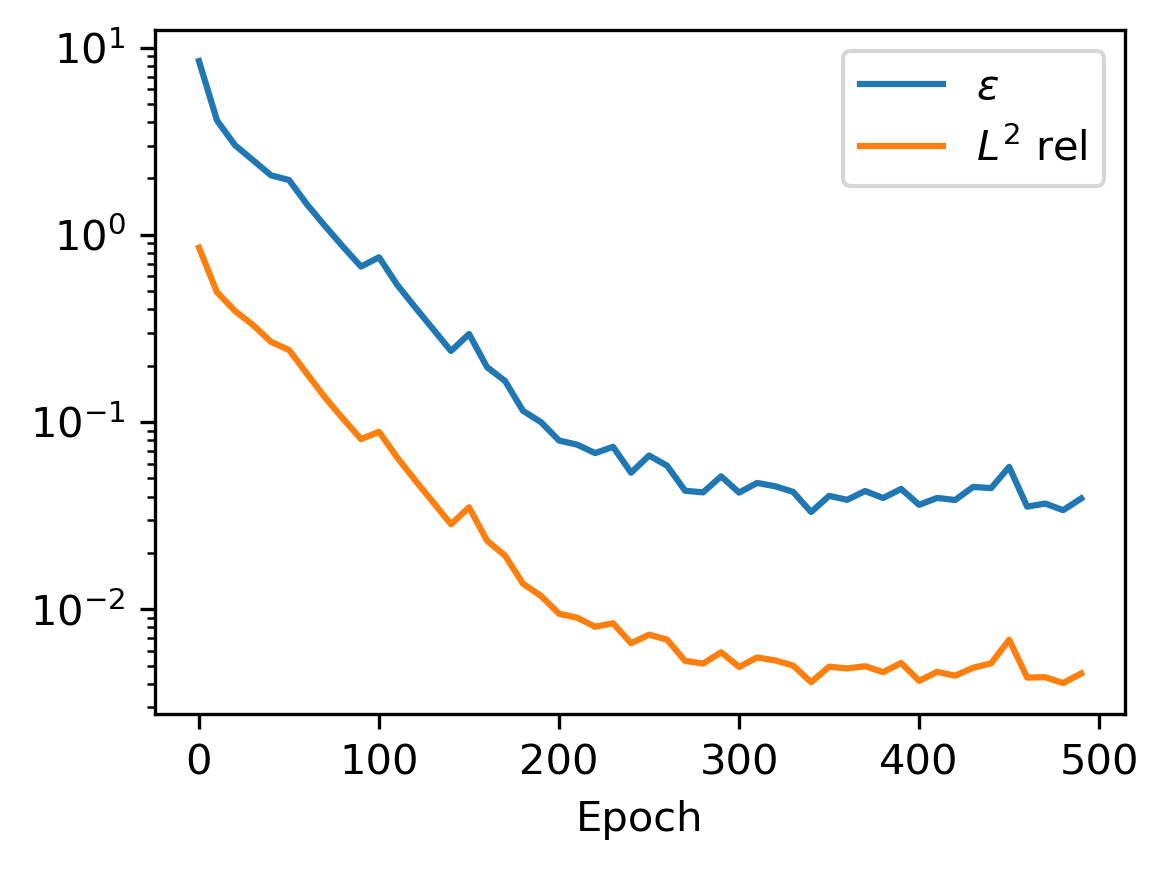

In [17]:
# Plotting the losses
fig=plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)

loss_array = np.array(model.loss_log)
emdgt_array = np.array(model.emdgt_log)
l2rel_log = np.array(model.l2rel_log)
ax.plot(model.it_log, loss_array - lambda1 * emdgt_array, label=r'$\epsilon$')
ax.plot(model.it_log, l2rel_log, label=r'$L^2$ rel')
plt.yscale('log')

plt.xlabel('Epoch')
plt.tight_layout()

plt.legend()

plt.savefig('Gaussian_loss.eps', format='eps', dpi=300)
plt.show()

In [18]:
def hist2dplot(x, y, ax1, labels=['1', '2'], xylims=None, vmin=None, vmax=None):
    if xylims is None:
        H, xedges, yedges = np.histogram2d(x, y, 20, density=True)
    else:
        H, xedges, yedges = np.histogram2d(x, y, 20, density=True, 
                                         range=[[xylims[0], xylims[1]], 
                                               [xylims[2], xylims[3]]])
    H = H.T
    cax = ax1.pcolormesh(xedges, yedges, H, vmin=vmin, vmax=vmax)
    pbar = plt.colorbar(cax, ax=ax1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.grid()
    
    return H, xedges, yedges

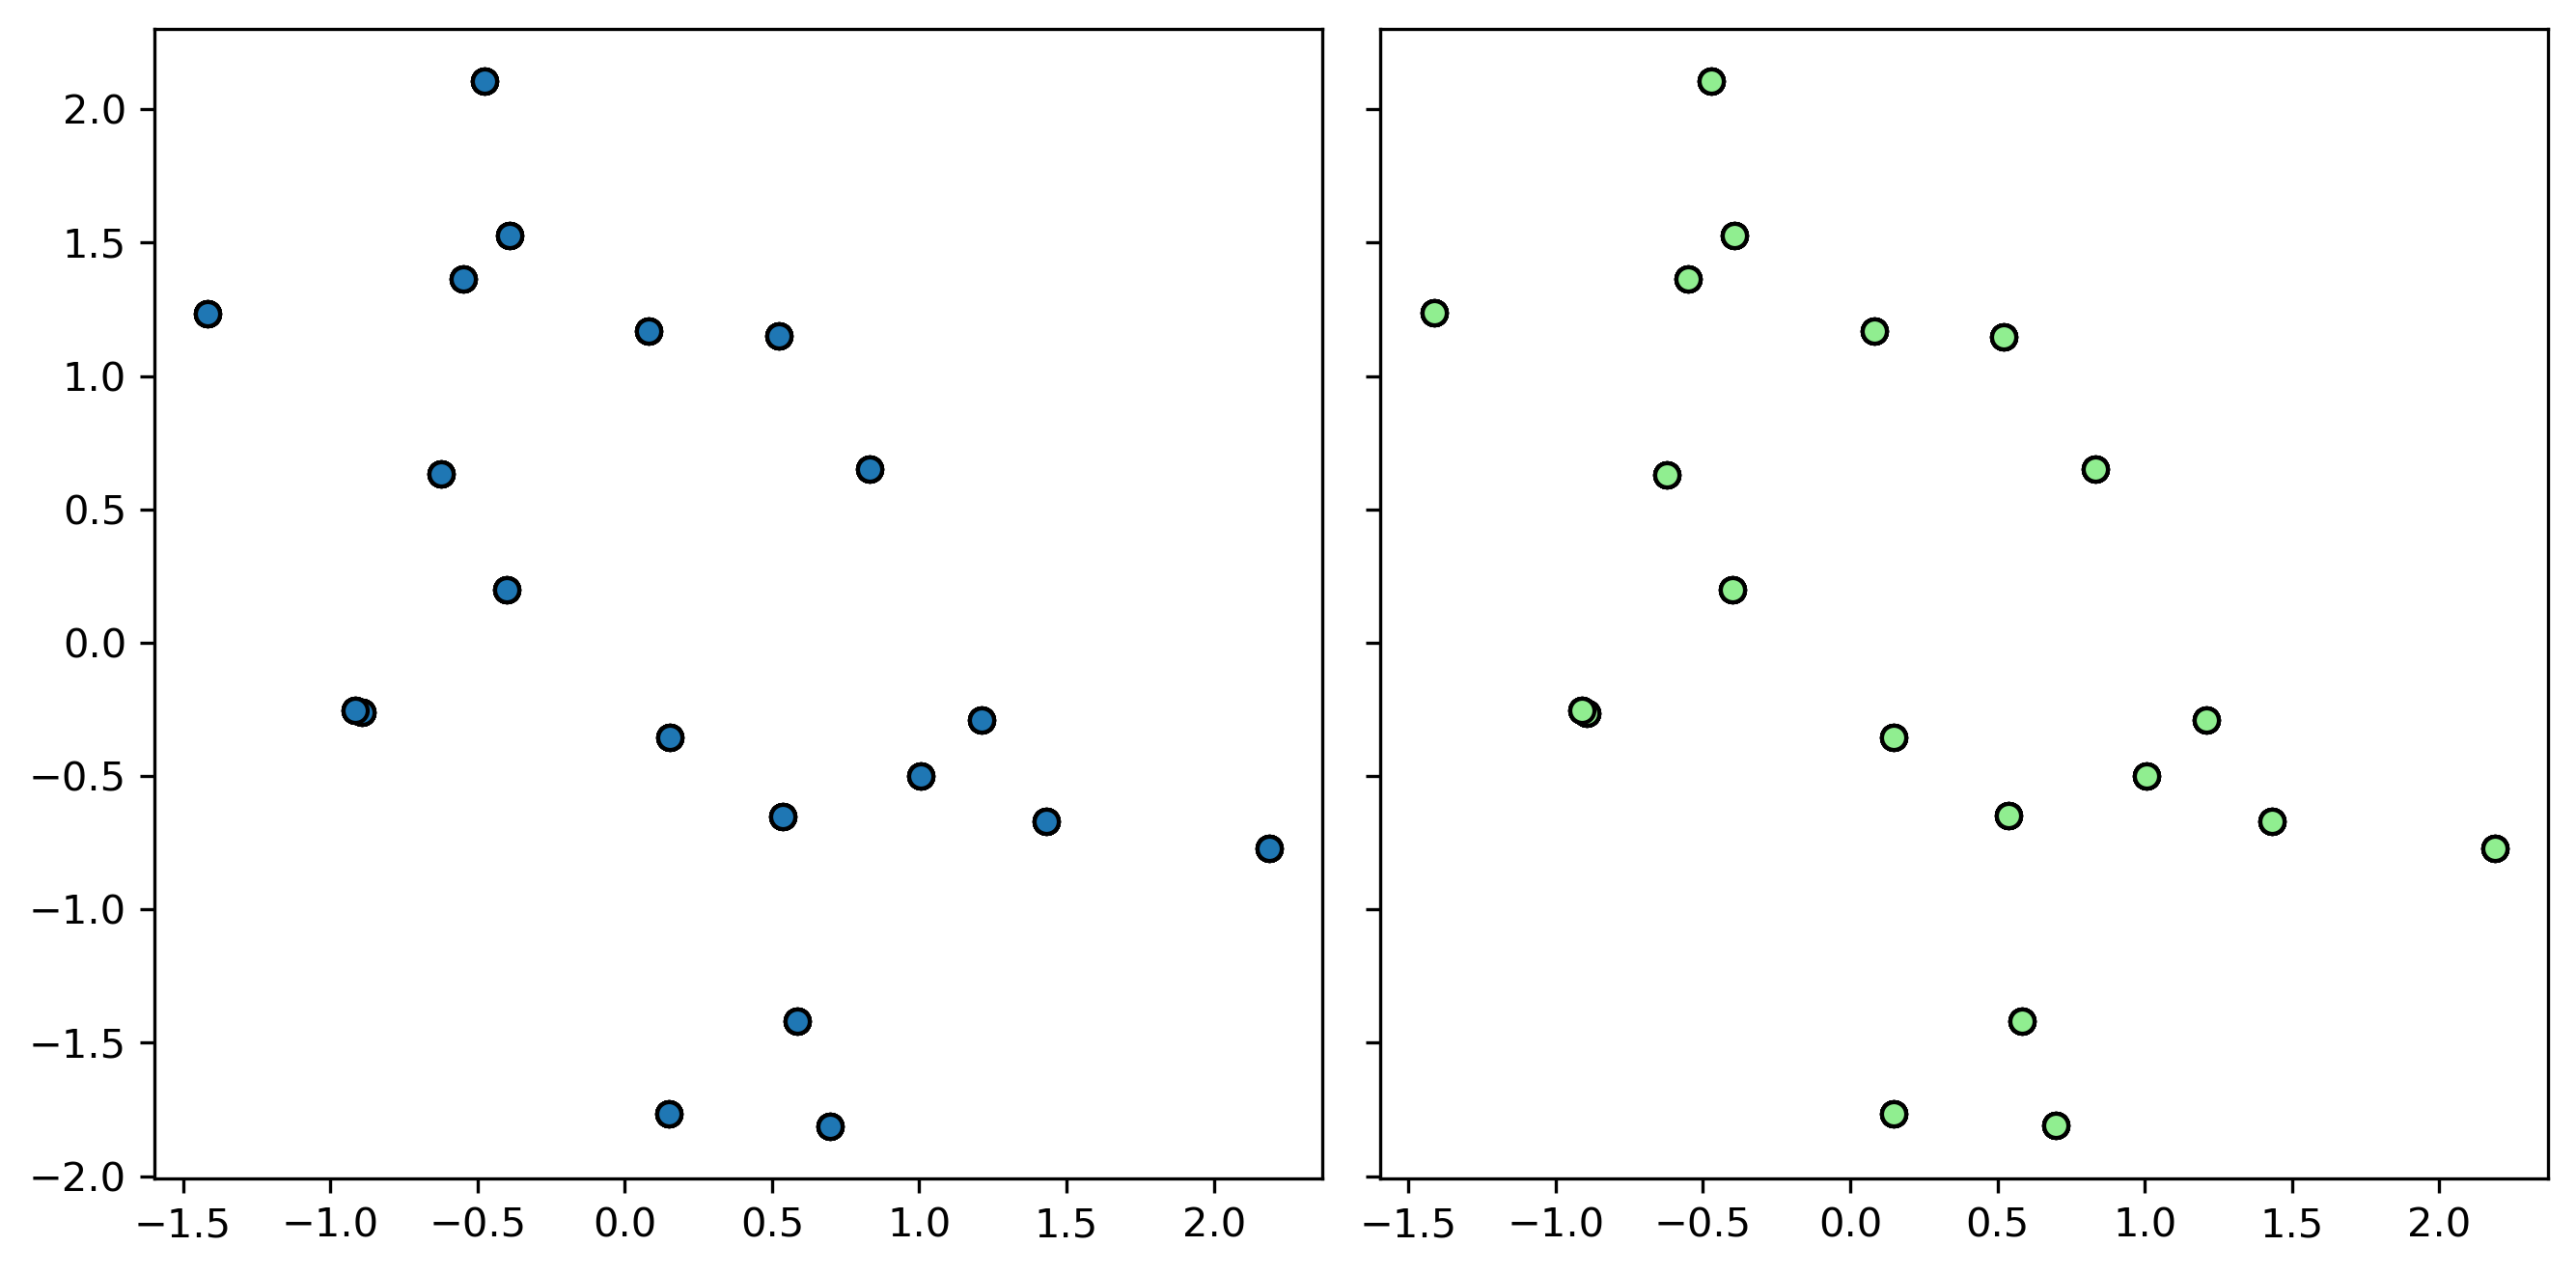

In [19]:
key = random.PRNGKey(0)
key, key_s = random.split(key, 2)
s = None
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), dpi=300, sharex=True, sharey=True)
dict_n = 10
xpre = jnp.zeros(shape=[dict_n, 20, dim])
for i in range(dict_n):
    xpre = xpre.at[i, :, :].set(Generator(rng_key = key, size = 20, rotation_matrix = rotation_source))
params = model.get_params(model.opt_state)
f_pred = jax.device_get(model.predict(params, xpre))
f_ref =  exact_transport_map(xpre)

axes[0].scatter(f_ref[:, :, 0], f_ref[:, :, 1], edgecolors='black', s=s)
axes[1].scatter(f_pred[:, :, 0], f_pred[:, :, 1], c='lightgreen', edgecolors='black', s=s)

#axes[0].set_title(r'Ground Truth $\mathbb{Q}$ project to (0,1) dimension ', fontsize=12)
#axes[1].set_title(r'Network Prediction $\mathbb{Q}$', fontsize=12)
fig.tight_layout()
plt.savefig('Transport_comparison.eps', format='eps', dpi=300)
plt.show()